In [2]:

# Geral
import random
import pydot
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Grafo
from networkx.drawing.nx_pydot import write_dot
import networkx as nx


# Mapa e calculo de distancia pela latitude e longitude
from mpl_toolkits.basemap import Basemap
from geopy import distance
from geopy.distance import geodesic
from haversine import haversine

# Algoritimo Genetico
from deap import base, creator, tools, algorithms

Melhor rota encontrada: ['Macapá', 'Belém', 'Natal', 'Olinda', 'Maceió', 'Aracaju', 'Salvador', 'Belo Horizonte', 'Duque de Caxias', 'Osasco', 'Curitiba']


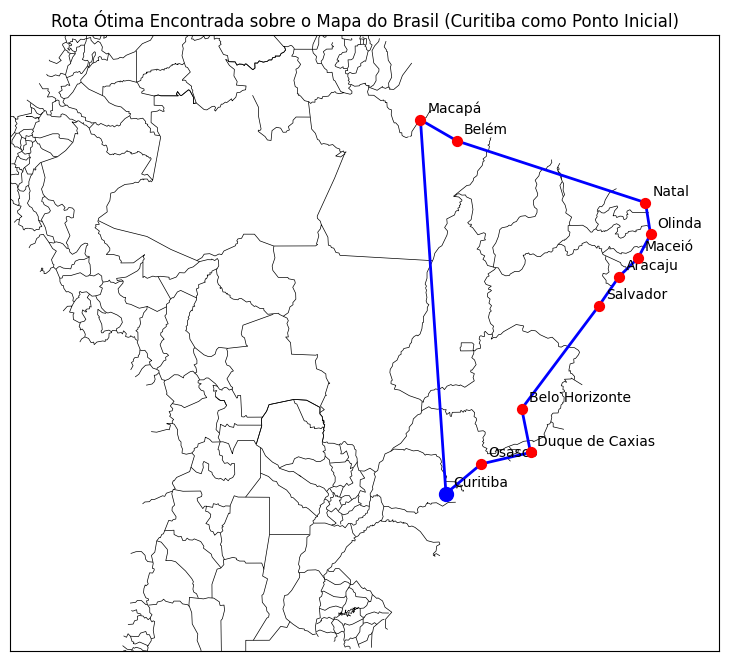

In [3]:

# Transforma os dados do csv em lista
def extract_csv_cities_file():
    path = './Lista_cidades_cc.csv'
    with open(path, 'r') as file:
        csv_reader = csv.reader(file)
        info_cities = []
        
        for i in csv_reader:
            info_cities.append(i)

    return [[city, float(lat), float(lon)] for city, lat, lon in info_cities]

# Função para calcular a distância entre duas cidades
def distance(city1, city2):
    lat1, lon1 = city1[1], city1[2]
    lat2, lon2 = city2[1], city2[2]
    return np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)

# Função de avaliação (fitness)
def evaluate(individual):
    distance_sum = 0
    for i in range(len(individual) - 1):
        city1 = city_data[individual[i]]
        city2 = city_data[individual[i + 1]]
        distance_sum += distance(city1, city2)
    return distance_sum,

# Seleciona o número de cidades que o caminhão vai passar.
def select_cities():
    cities = extract_csv_cities_file()
    curitiba = [city for city in cities if city[0] == 'Curitiba']
    other_cities = [city for city in cities if city[0] != 'Curitiba']

    num_cities = int(input('Enter the number of cities (must be greater than 4 and less than 50): '))

    if num_cities < 4 or num_cities > 50:
        return 'Please enter with a valid numbers of cities'

    selected_other_cities = random.sample(other_cities, k=num_cities - 1)
    random.shuffle(selected_other_cities)
    
    return curitiba + selected_other_cities

# Pegar lista de cidades selecionadas
city_data = select_cities()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registrar operações genéticas
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(city_data)), len(city_data))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Parâmetros do algoritmo genético
population_size = 100
num_generations = 1000

# Criar população inicial
population = toolbox.population(n=population_size)

# Rodar o algoritmo genético
for gen in range(num_generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Obter o melhor indivíduo (rota)
best_individual = tools.selBest(population, k=1)[0]
best_route = [city_data[i][0] for i in best_individual]

print("Melhor rota encontrada:", best_route)

# Plotar o mapa do Brasil
plt.figure(figsize=(10, 8))
mapa = Basemap(projection='merc', llcrnrlat=-35, urcrnrlat=6, llcrnrlon=-80, urcrnrlon=-30, resolution='l', lat_0=-15, lon_0=-50)
mapa.drawcountries(color='black')
mapa.drawstates(color='black')

# Plotar as cidades
for city in city_data:
    x, y = mapa(city[2], city[1])
    if city[0] == 'Curitiba':
        mapa.scatter(x, y, s=100, color='blue', zorder=10)  # Marcar Curitiba com uma cor diferente
    else:
        mapa.scatter(x, y, s=50, color='red', zorder=10)

    plt.annotate(city[0], xy=(x, y), xytext=(5, 5), textcoords='offset points', color='black')

# Plotar a rota ótima
for i in range(len(best_route) - 1):
    city1 = city_data[best_individual[i]]
    city2 = city_data[best_individual[i + 1]]
    x1, y1 = mapa(city1[2], city1[1])
    x2, y2 = mapa(city2[2], city2[1])
    mapa.plot([x1, x2], [y1, y2], 'bo-', linewidth=2)

# Plotar a última ligação da rota
city1 = city_data[best_individual[-1]]
city2 = city_data[best_individual[0]]
x1, y1 = mapa(city1[2], city1[1])
x2, y2 = mapa(city2[2], city2[1])
mapa.plot([x1, x2], [y1, y2], 'bo-', linewidth=2)

plt.title('Rota Ótima Encontrada sobre o Mapa do Brasil (Curitiba como Ponto Inicial)')
plt.show()